<a href="https://colab.research.google.com/github/MaulanaJauhar/MachineLearning/blob/main/Week10/Meet10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modul 10 - Recurrent Neural Network (RNN)
> Machine Learning - Recurrent Neural Network (RNN)

##Nama : Jauhar Maulana A'la
##NIM : 2141720186
##Kelas : TI - 3A

###Praktikum 1
> RNN untuk Analisis Sentimen

####Setup
> Import Library Matplotlib, lalu membuat fungsi untuk memplot grafik

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
# Construct a tf.data.Dataset
ds = tfds.load('imdb_reviews', split='train', shuffle_files=True)

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
 plt.plot(history.history[metric])
 plt.plot(history.history['val_'+metric], '')
 plt.xlabel("Epochs")
 plt.ylabel(metric)
 plt.legend([metric, 'val_'+metric])

####Setup Input Pipeline
> Download dataset ulasan film IMDB menggunakan TFDS

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

> Mengembalikan dataset (teks, pasangan label)

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


> Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label)

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'I\'m sorry but this is just awful. I have told people about this film and some of the bad acting that is in it and they almost don\'t believe me. There is nothing wrong with the idea, modern day Japanese troops get pulled back in time to the days of Busido warriors and with their modern weapons are a match for almost everything. When the troops first realise something strange is happening does every single person in the back of the transport need to say "Hey my watch has stopped"? Imagine lines like that being repeated 15+ times before they say anything else and you have the movie\'s lack of greatness in a nutshell.'
 b"SPOILER ALERT ! ! ! Personally I don't understand why Pete did not help to save Williams life,I mean that would be great to know why William was motivated,or forced.I think Secret Service members are every day people,and there is a rumor the writer was a member of the Secret Service,now he's motivations are clear,well known.But as a rental this film will not 

####Buat Teks Encoder
> Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

> Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [ ]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

> Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [ ]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[142, 786,  19, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [ 10, 284,   1, ...,   0,   0,   0]])

> Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu: Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation" dan ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I\'m sorry but this is just awful. I have told people about this film and some of the bad acting that is in it and they almost don\'t believe me. There is nothing wrong with the idea, modern day Japanese troops get pulled back in time to the days of Busido warriors and with their modern weapons are a match for almost everything. When the troops first realise something strange is happening does every single person in the back of the transport need to say "Hey my watch has stopped"? Imagine lines like that being repeated 15+ times before they say anything else and you have the movie\'s lack of greatness in a nutshell.'
Round-trip:  im sorry but this is just awful i have told people about this film and some of the bad acting that is in it and they almost dont believe me there is nothing wrong with the idea modern day japanese [UNK] get [UNK] back in time to the days of [UNK] [UNK] and with their modern [UNK] are a [UNK] for almost everything when the [UNK] first [UNK] somethi

####Buat Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

> Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi.

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


> Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.00475861]


> Evaluasi lagi dalam batch dengan kalimat yang lebih panjang

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 64ms/step
[0.00475861]


> Compile model Keras untuk mengonfigurasi proses pelatihan

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

####Train Model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 54s 104ms/step - loss: 0.6577 - accuracy: 0.5605 - val_loss: 0.5633 - val_accuracy: 0.6453
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.4622 - accuracy: 0.7867 - val_loss: 0.3902 - val_accuracy: 0.8245
Epoch 3/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3588 - accuracy: 0.8399 - val_loss: 0.3519 - val_accuracy: 0.8396
Epoch 4/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3326 - accuracy: 0.8559 - val_loss: 0.3525 - val_accuracy: 0.8552
Epoch 5/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3198 - accuracy: 0.8614 - val_loss: 0.3367 - val_accuracy: 0.8500
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3116 - accuracy: 0.8666 - val_loss: 0.3281 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3106 - accuracy: 0.8651 - val_loss: 0.3228 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3204 - accuracy: 0.8568
Test Loss: 0.32042932510375977
Test Accuracy: 0.8567600250244141


(0.0, 0.6755493849515914)

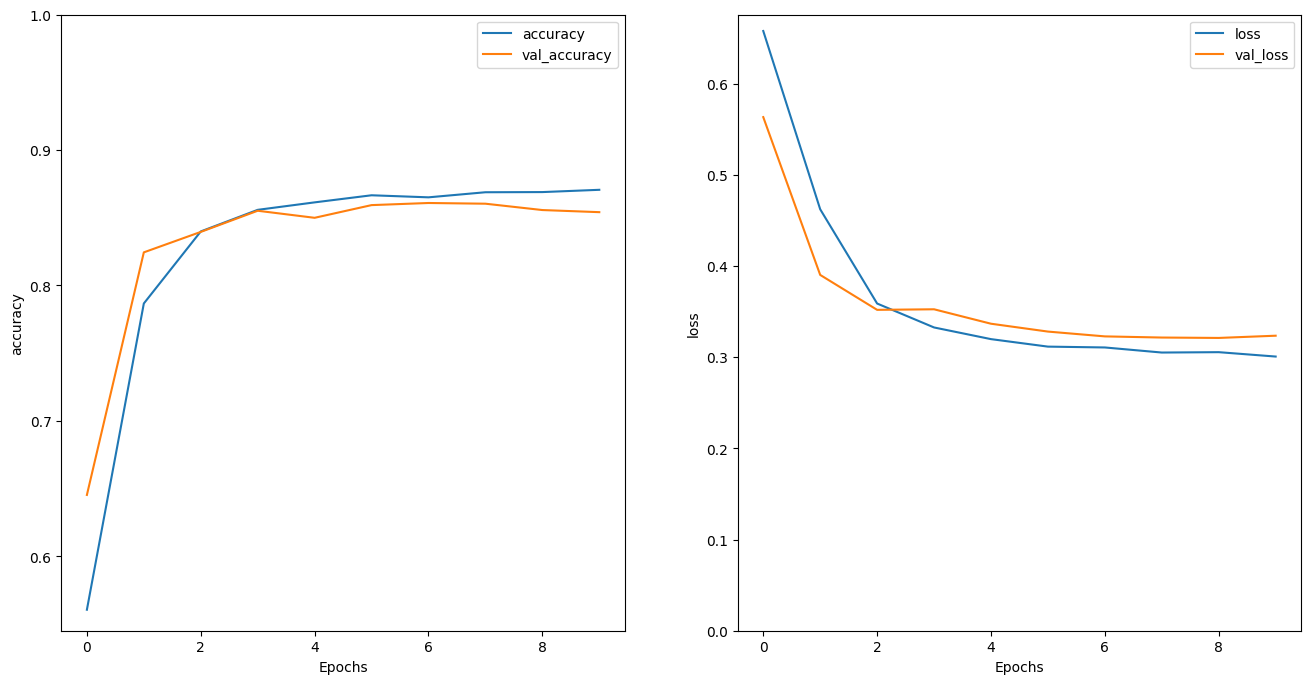

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

> Jalankan prediksi pada kalimat baru: Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


####Stack two or more LSTM layers

> Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :
> Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
> Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

> Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 80s 149ms/step - loss: 0.6251 - accuracy: 0.5928 - val_loss: 0.4378 - val_accuracy: 0.8036
Epoch 2/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3898 - accuracy: 0.8323 - val_loss: 0.3522 - val_accuracy: 0.8427
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3437 - accuracy: 0.8554 - val_loss: 0.3316 - val_accuracy: 0.8464
Epoch 4/10
391/391 [==============================] - 44s 112ms/step - loss: 0.3228 - accuracy: 0.8661 - val_loss: 0.3245 - val_accuracy: 0.8464
Epoch 5/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3147 - accuracy: 0.8681 - val_loss: 0.3193 - val_accuracy: 0.8599
Epoch 6/10
391/391 [==============================] - 44s 112ms/step - loss: 0.3065 - accuracy: 0.8701 - val_loss: 0.3151 - val_accuracy: 0.8604
Epoch 7/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3060 - accuracy: 0.8693 - val_loss: 0.3167 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 22s 57ms/step - loss: 0.3344 - accuracy: 0.8632
Test Loss: 0.33438101410865784
Test Accuracy: 0.8631600141525269


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-2.0759974]]


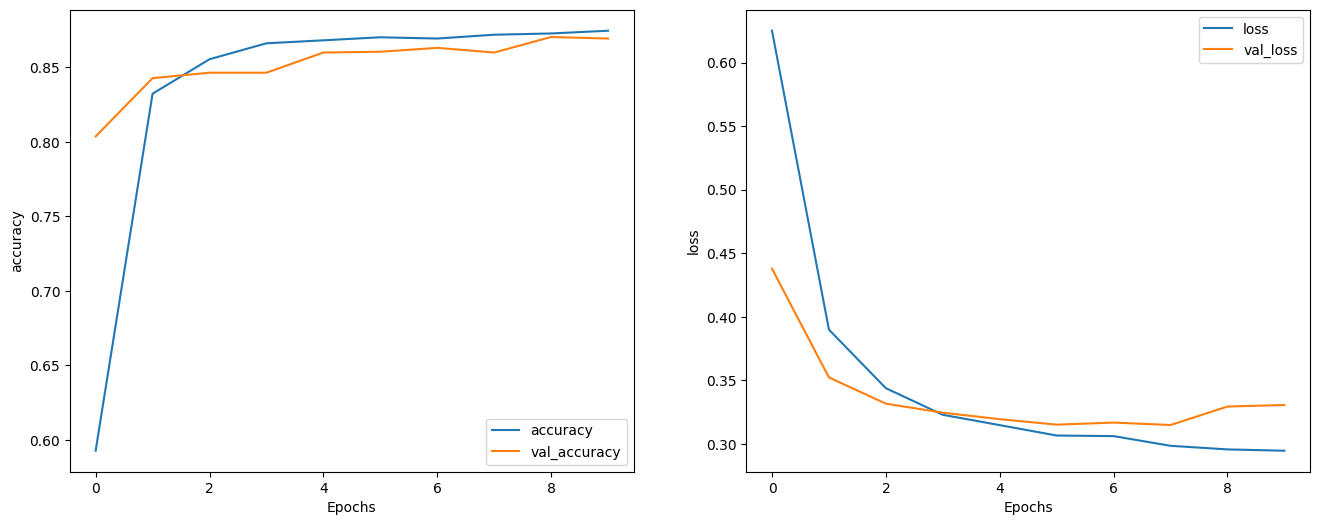

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

###Praktikum 2
> Generator Teks dengan RNN

####Setup

#####Import Tersorflow dan Download Dataset Shakespeare

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

####Load Data

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


####Olah Teks

#####Vectorize Teks

> Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. tf.keras.layers.StringLookup dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

> tf.keras.layers.StringLookup

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

> perintah diatas mengconvert token menjadi id

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

> menggunakan metode get_vocabulary() dari tf.keras.layers.StringLookup sehingga token [UNK] disetel dengan cara yang sama

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

> Convert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter tf.RaggedTensor

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

> menggunakan tf.strings.reduce_join untuk menggabungkan kembali karakter menjadi string.

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

####Prediksi

#####Membuat Trianing Set dan Target

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


> menggabungkan token kembali menjadi string

In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


> mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu

In [ ]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


#####Membuat Batch Training

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

####Buat Model

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

####Uji Model

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     multiple                  16896     
                                                                 
 gru_2 (GRU)                 multiple                  3938304   
                                                                 
 dense_6 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> mengambil sampel dari distribusi keluaran, untuk mendapatkan indeks karakter aktual.

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([52, 15,  3, 45, 30, 20, 47, 57, 13, 33, 61, 57, 57, 18, 60, 16, 51,
       59, 36, 62, 30, 61, 61, 27, 53, 61, 51,  7, 22, 19,  2, 49, 21, 43,
       64, 36, 47, 52, 64, 15,  3,  4, 21, 23,  7, 25, 13,  5,  4, 14, 58,
       55, 13, 44,  2, 52, 17, 54, 13, 64,  1, 15,  6, 60, 53, 36, 39,  5,
       62, 10, 51, 25, 38, 56, 57, 63, 56, 36, 25,  9,  3, 50,  6, 64,  8,
       20, 33, 23, 48, 30, 33,  8, 39, 19, 54, 41, 65, 24, 52, 13])

> melihat teks yang diprediksi oleh model tidak terlatih ini

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'uite thy kindness,\nFor that it made my imprisonment a pleasure;\nAy, such a pleasure as incaged birds'

Next Char Predictions:
 b"mB!fQGhr?TvrrEuCltWwQvvNnvl,IF jHdyWhmyB!$HJ,L?&$Asp?e mDo?y\nB'unWZ&w3lLYqrxqWL.!k'y-GTJiQT-ZFobzKm?"


####Train Model

#####Tambahan Optimizer dan Fungsi Loss

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.190194, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.03561

> Konfigurasikan prosedur pelatihan menggunakan metode tf.keras.Model.compile.

In [ ]:
model.compile(optimizer='adam', loss=loss)

#####Konfigurasi Checkpoint

> Menggunakan tf.keras.callbacks.ModelCheckpoint untuk memastikan bahwa checkpoint disimpan selama pelatihan:

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

#####Proses Training

In [ ]:
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
172/172 [==============================] - 13s 57ms/step - loss: 2.7118
Epoch 2/30
172/172 [==============================] - 12s 56ms/step - loss: 1.9858
Epoch 3/30
172/172 [==============================] - 12s 57ms/step - loss: 1.7052
Epoch 4/30
172/172 [==============================] - 12s 58ms/step - loss: 1.5453
Epoch 5/30
172/172 [==============================] - 12s 58ms/step - loss: 1.4474
Epoch 6/30
172/172 [==============================] - 12s 58ms/step - loss: 1.3786
Epoch 7/30
172/172 [==============================] - 12s 58ms/step - loss: 1.3268
Epoch 8/30
172/172 [==============================] - 11s 57ms/step - loss: 1.2816
Epoch 9/30
172/172 [==============================] - 11s 56ms/step - loss: 1.2404
Epoch 10/30
172/172 [==============================] - 12s 58ms/step - loss: 1.2013
Epoch 11/30
172/172 [==============================] - 12s 59ms/step - loss: 1.1603
Epoch 12/30
172/172 [==============================] - 12s 59ms/step - loss: 1.1187
E

#####Generate Teks

> membuat prediksi satu langkah:

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
The very letting fearful throne in service,
That replains what it is great, the princes head,
Having left not to confirm my wife's ends in
The season. Cried, heartily:
You know not what I lay come to you.

Lord:
Here is a there, where, she?

AUFIDIUS:
Every wink,
Who golded issue of his father's name in Mariana
Ad, cried 'God save thee, of they are at them;
But they prettyang instruments for good aid?
And were I often has my trencher heir
Than all the house. For inspire, which we
Come I have singled offer of an are:
If thou remember'st my tale: if Henry,
Before show thy descent; if your
very heart as yet unbree: in all things and usures smote:
Pardon me, God, I rumpty love, against our suits is warm.

LEONTES:
To see your taints profoging the foe,
And from the Duke off unhalp'd Edward's wrings good abound.
Lord Angelo is separazed for any thing; but if
He comes to weap or reasons.

HERMIONE:
So it is,
And these kiss'd instructed arms.

BIANCA:
Why, here's a fairer dather least i

> contoh di bawah, model menghasilkan 5 keluaran dalam waktu yang hampir sama dengan waktu yang dibutuhkan untuk menghasilkan 1 keluaran di atas.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nThe better to the cause. I have fear'd and brok no world!\nThis dead love's peace upon this pocken royal att\ncunniniss; spake it forth, though consumed with her extremity,\nWhich essay neighing gentleman, I would not pardon me;\nUncover with the prince, affords foregean's\npulsers.\n\nTISTAN:\n\nBROKE:\nCome, thou hast spoke hot ever.\n\nANGOLIO:\nWe must perceaits that we will, in every pate\nBut tie Anon it meets His woundst told watch?\nO, but what my poor brief have given him good\nTill ourselves agroubt? Was this the matter,\nThe trial of Oxford to Hastings.\n\nGLOUCESTER:\nShe shall not live so bring the prince who straight declined, howbed,\nTo be necessity look on revenge\nOn the shadow and tired deligs,\nEven would have fear'd time to visit them: Edward, cut off,\nAnd till I pillate it;\nAnd I am in health! What, ho! your brewicce:\nGod's worst in good regise, and here long tame\nAnd with her brains of resolution, where thou must ricke: prove it, in exac

#####Ekspor Model Generator

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
The queen your most relood, to
report, some think it well and love him well.

FRIAR LAURENCE:
Who s


###Tugas Praktikum

Prosedur pelatihan pada praktikum 2 merupakan prosedur sederhana, yang tidak memberi Anda banyak kendali. Model ini menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan. Jadi, setelah Anda melihat cara menjalankan model secara manual, selanjutnya Anda akan mengimplementasikan custom loop pelatihan. Hal ini memberikan titik awal jika, misalnya, Anda ingin menerapkan pembelajaran kurikulum untuk membantu menstabilkan keluaran open-loop model. Bagian terpenting dari loop pelatihan khusus adalah fungsi langkah pelatihan.

Gunakan tf.GradientTape untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca eager execution guide.

Prosedurnya adalah "
1. Jalankan Model dan hitung loss dengan tf.
GradientTape.
2. Hitung update dan terapkan pada model dengan optimizer

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 17s 65ms/step - loss: 2.7178


In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1661
Epoch 1 Batch 50 Loss 2.0753
Epoch 1 Batch 100 Loss 1.9304
Epoch 1 Batch 150 Loss 1.8331

Epoch 1 Loss: 1.9877
Time taken for 1 epoch 12.42 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8045
Epoch 2 Batch 50 Loss 1.7518
Epoch 2 Batch 100 Loss 1.6894
Epoch 2 Batch 150 Loss 1.6336

Epoch 2 Loss: 1.7096
Time taken for 1 epoch 10.78 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6441
Epoch 3 Batch 50 Loss 1.5622
Epoch 3 Batch 100 Loss 1.5549
Epoch 3 Batch 150 Loss 1.5104

Epoch 3 Loss: 1.5479
Time taken for 1 epoch 10.90 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.5050
Epoch 4 Batch 50 Loss 1.4427
Epoch 4 Batch 100 Loss 1.4720
Epoch 4 Batch 150 Loss 1.4539

Epoch 4 Loss: 1.4494
Time taken for 1 epoch 10.97 sec
_____________________________________________________________________

> Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?

> Perbedaan kode diatas dengan praktikum 2 yaitu pada praktikum 2 tidak memberi kita banyak kendali atas pelatihan. praktikum 2 menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan.